In [2]:
import numpy as np

np.arange(5)

array([0, 1, 2, 3, 4])

In [24]:
# encode type

n_types = 5
t = 1
board = np.array([[-1, -1, -1], [-1, 1, -1], [-1, 1, 1]])

print("board")
print(board)
print("type")
print(t)

enc_types = np.zeros(n_types, dtype=bool)
enc_types[t] = 1

enc_board = (board==1).flatten()
print("enc_board")
print(enc_board)

print("enc_types")
print(enc_types)

occ = np.hstack((enc_board, enc_types))
print("occ")
print(occ)

pow = 1<<np.arange(occ.size)
print("pow")
print(pow)

code = pow@occ
print("code")
print(code)


def encode_state(n_tiles, board, tile_type):
    enc_types = np.zeros(n_tiles, dtype=bool)
    enc_types[tile_type] = 1
    enc_board = (board==1).flatten()

    occ = np.hstack((enc_board, enc_types))
    pow = 1 << np.arange(occ.size)
    code = pow@occ

    return code


print("func output")
encode_state(n_types, board, t)



board
[[-1 -1 -1]
 [-1  1 -1]
 [-1  1  1]]
type
1
enc_board
[False False False False  True False False  True  True]
enc_types
[False  True False False False]
occ
[False False False False  True False False  True  True False  True False
 False False]
pow
[   1    2    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
code
1424
func output


1424

In [31]:
n_pos = 10
n_ori = 4

tile_positions = np.arange(n_pos)
tile_orientations = np.arange(n_ori)

tile_positions = np.repeat(np.arange(n_pos, dtype=int), n_ori)
tile_orientations = np.tile(np.arange(n_ori, dtype=int), n_pos)
actions = np.vstack((tile_positions, tile_orientations)).T
actions

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [6, 0],
       [6, 1],
       [6, 2],
       [6, 3],
       [7, 0],
       [7, 1],
       [7, 2],
       [7, 3],
       [8, 0],
       [8, 1],
       [8, 2],
       [8, 3],
       [9, 0],
       [9, 1],
       [9, 2],
       [9, 3]])

In [18]:
import gmpy2

int(gmpy2.pack([1 for _ in range(65)], 1))

36893488147419103231

In [212]:
import numpy as np
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SmallStateAutoEncoder(nn.Module):
    def __init__(self, d_L, d_H) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Flatten(1),   # dim 
            nn.Linear(256, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_L),
            nn.ReLU(),
        )        

        self.decoder = nn.Sequential(
            nn.Linear(d_L, d_H),
            nn.ReLU(),
            nn.Linear(d_H, 256),
            nn.ReLU(),
            nn.Unflatten(1, (16, 4, 4)),
            nn.ConvTranspose2d(16, 1, 1, stride=1, padding=0),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.tanh(x)
        

In [206]:
import numpy as np

data = np.random.choice([-1, 1], size=(128, 128, 1, 4, 4))
data = torch.Tensor(data)


In [213]:
ae = SmallStateAutoEncoder(8, 64).to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=2E-4)

losses = []
run_loss = 0
n_epochs = 100

ae.train()
for epoch in range(n_epochs):
    print(f'epoch: {epoch}/{n_epochs}')

    run_loss = 0
    for x in data:
        optim.zero_grad()
        x = x.to(device)

        y = ae(x)

        loss = loss_fn(y, x)
        run_loss += loss.item()

        loss.backward()
        optim.step()

    train_loss = run_loss / len(data)

    print(f'loss: {train_loss}')
    losses.append(train_loss)



epoch: 0/100
loss: 0.9858828182332218
epoch: 1/100
loss: 0.8289815257303417
epoch: 2/100
loss: 0.7625264227390289
epoch: 3/100
loss: 0.751639848574996
epoch: 4/100
loss: 0.7457544035278261
epoch: 5/100
loss: 0.7406589705497026
epoch: 6/100
loss: 0.7357798488810658
epoch: 7/100
loss: 0.7305281576700509
epoch: 8/100
loss: 0.7234605723060668
epoch: 9/100
loss: 0.7121640909463167
epoch: 10/100
loss: 0.6876952759921551
epoch: 11/100
loss: 0.6226979345083237
epoch: 12/100
loss: 0.5616236794739962
epoch: 13/100
loss: 0.5447219354100525
epoch: 14/100
loss: 0.5361014707013965
epoch: 15/100
loss: 0.5287122414447367
epoch: 16/100
loss: 0.5221467805095017
epoch: 17/100
loss: 0.5162966407369822
epoch: 18/100
loss: 0.5110815574880689
epoch: 19/100
loss: 0.5063164562452585
epoch: 20/100
loss: 0.5019847068469971
epoch: 21/100
loss: 0.49783361214213073
epoch: 22/100
loss: 0.4937441870570183
epoch: 23/100
loss: 0.4896081027109176
epoch: 24/100
loss: 0.48523278813809156
epoch: 25/100
loss: 0.480551562737

[[11.689078  33.312435   0.         7.3474307  0.        15.756741
  16.56565    3.162099 ]]


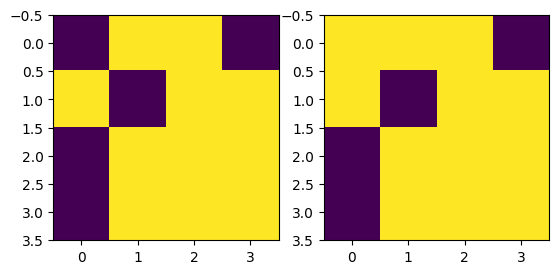

In [204]:
import matplotlib.pyplot as plt

ex_grid = np.array([[-1, 1, 1, -1], [1, -1, 1, 1], [-1, 1, 1, 1], [-1, 1, 1, 1]])
ex_grid = ex_grid.reshape(1, 1, 4, 4)
ex_grid = torch.Tensor(ex_grid).to(device)

ae.eval()
ex_y = torch.sgn(ae(ex_grid))
print(ae.encoder(ex_grid).detach().cpu().numpy())

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ex_grid.detach().cpu().numpy().squeeze())
ax2.imshow(ex_y.detach().cpu().numpy().squeeze())

In [225]:
import numpy as np
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LargeStateAutoEncoder(nn.Module):
    def __init__(self, d_L, d_H) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Flatten(1),   # dim 
            nn.Linear(4096, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_L),
            nn.ReLU(),
        )        

        self.decoder = nn.Sequential(
            nn.Linear(d_L, d_H),
            nn.ReLU(),
            nn.Linear(d_H, 4096),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 1, 1, stride=1, padding=0),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.tanh(x)
        

In [226]:
import numpy as np

data = np.random.choice([-1, 1], size=(128, 128, 1, 8, 8))
data = torch.Tensor(data)


In [227]:
ae = LargeStateAutoEncoder(8, 64).to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=2E-4)

losses = []
run_loss = 0
n_epochs = 100

ae.train()
for epoch in range(n_epochs):
    print(f'epoch: {epoch}/{n_epochs}')

    run_loss = 0
    for x in data:
        optim.zero_grad()
        x = x.to(device)

        y = ae(x)

        loss = loss_fn(y, x)
        run_loss += loss.item()

        loss.backward()
        optim.step()

    train_loss = run_loss / len(data)

    print(f'loss: {train_loss}')
    losses.append(train_loss)



epoch: 0/100


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x6400 and 4096x64)

: 

In [ ]:
import matplotlib.pyplot as plt

ex_grid = np.array([
    [-1, 1, 1, -1, 1, 1, 1, -1],
    [1, -1, 1, 1, 1, 1, -1, -1],
    [-1, 1, 1, 1, 1, 1, 1, 1],
    [-1, -1, -1, -1, -1, 1, 1, 1],
    [1, 1, 1, -1, 1, -1, -1, 1],
    [-1, -1, 1, -1, 1, 1, -1, 1],
    [1, -1, -1, 1, 1, 1, 1, -1],
    [-1, -1, -1, -1, 1, 1, 1, 1]])
ex_grid = ex_grid.reshape(1, 1, 8, 8)
ex_grid = torch.Tensor(ex_grid).to(device)

ae.eval()
ex_y = torch.sgn(ae(ex_grid))
print(ae.encoder(ex_grid).detach().cpu().numpy())

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ex_grid.detach().cpu().numpy().squeeze())
ax2.imshow(ex_y.detach().cpu().numpy().squeeze())

<>:7: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:7: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
C:\Users\gaspa\AppData\Local\Temp\ipykernel_20664\2040847715.py:7: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [-1, -1, -1, -1, -1, 1, 1, 1]
C:\Users\gaspa\AppData\Local\Temp\ipykernel_20664\2040847715.py:7: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [-1, -1, -1, -1, -1, 1, 1, 1]
C:\Users\gaspa\AppData\Local\Temp\ipykernel_20664\2040847715.py:7: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [-1, -1, -1, -1, -1, 1, 1, 1]


TypeError: list indices must be integers or slices, not tuple